In [14]:
import json, os, sys, math
sys.path.append("../scripts/formalism")
from dataset import *
from entropy import *
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
from pprint import pprint
from plottable import Table, ColumnDefinition
import matplotlib
from cycler import cycler
from matplotlib.colors import ListedColormap
colors = list(matplotlib.colormaps['tab10'].colors)
CMAP = colors + ['navy', 'olive', 'peru', 'deeppink', 'lightgreen', 'limegreen', 'gold', 'aqua', 'mediumorchid', 'darkred', 'teal']

In [42]:
N = list(range(30, 91, 10))
SPLITS = ["split2", "split3", "split4", "split5", "split6", "split7", "split8", "split9", "split12", "split13", "split14", "split15", "split16", "split17", "split18", "split19", "split20", "split21", "split22", "split23", "split24"]


In [6]:
def Transpose(triplets, apply_to_relations=[1]):
    tmp = []
    for t in triplets:
        if t[-1] in apply_to_relations: tmp.append((t[1], t[0], t[-1]))
        else: tmp.append(t)
    return tmp
def create_synthetic_df(split, num_nouns, transpose=False):
    nouns = list(range(num_nouns))
    train_triplets, test_triplets = eval(f"create_data_{split}")(nouns)
    if transpose: train_triplets, test_triplets = Transpose(train_triplets), Transpose(test_triplets)
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    return df

In [51]:
def COMPLETENESS_tworoles(num_nouns, df):
    CPL_at_r1 = len(set(df["O1"])) / num_nouns
    CPL_at_r2 = len(set(df["O2"])) / num_nouns
    return round(CPL_at_r1*100, 2), round(CPL_at_r2*100, 2)

In [59]:
def plot_CPL_table(scores, title):
    scores = dict(sorted(scores.items(), key=lambda x: x[1][0]))

    column_names = ["legend", "split_method"] + [f"#objs = {n}" for n in N]
    df = pd.DataFrame(columns=column_names)
    for i, s in enumerate(scores):
        df.loc[i] = [i, s] + [f"{x[0]:.1f} | {x[1]:.1f}" for x in scores[s]]
    df = df.set_index("legend")

    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    col_defs = [ColumnDefinition(
                name="legend",
                border="",
                width=0.6,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.05},
                    "alpha": 0,
                },
                cmap=matplotlib.cm.tab10, #normed_cmap(df['legend'], cmap=matplotlib.cm.tab10, num_stds=2.5),
            ),
            ColumnDefinition(
                name="split_method",
                title="split_method",
                border="left right",
                width=1.0,
                textprops={"ha": "left", "fontsize": 10},
            )] + [ 
            ColumnDefinition(
                name=f"#objs = {n}",
                title=f"#objs = {n}",
                border="",
                textprops={"ha": "right", "fontsize": 10},
            ) for n in N]

    tab = Table(df,
                ax=ax,
                column_definitions = col_defs,
                column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.2},
                footer_divider=True,
                )
    ax.set_title(title)
    plt.show()

 24%|██▍       | 5/21 [00:00<00:00, 45.69it/s]

100%|██████████| 21/21 [00:00<00:00, 39.49it/s]


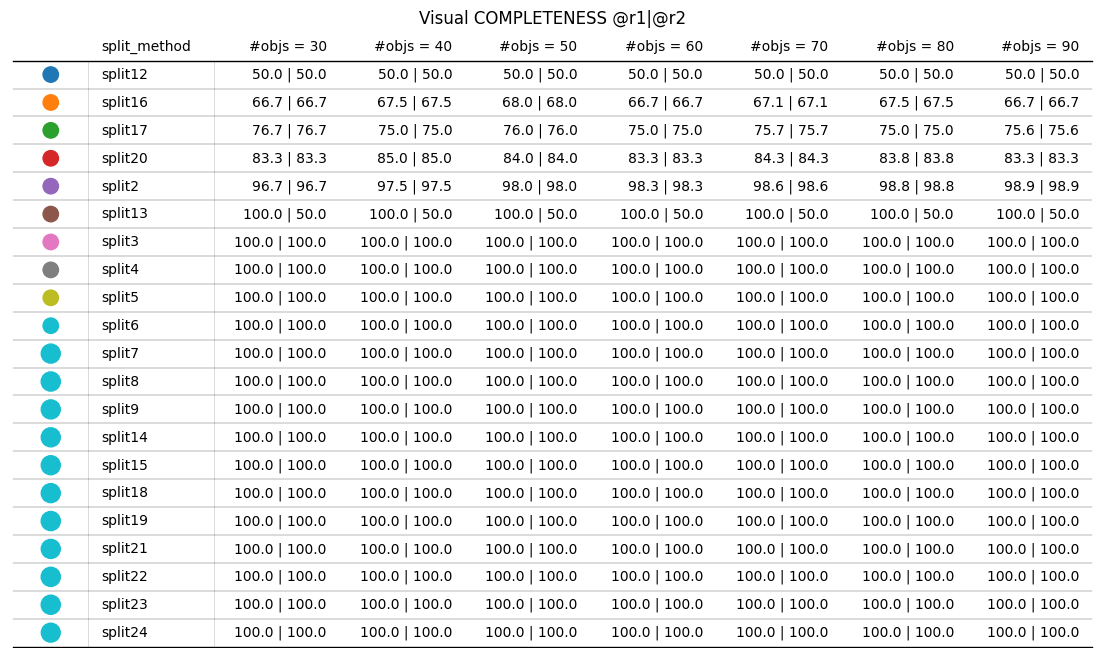

In [61]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=False)
        scores[split].append(COMPLETENESS_tworoles(num_nouns, df))
plot_CPL_table(scores, "Visual COMPLETENESS @r1|@r2")

100%|██████████| 21/21 [00:00<00:00, 32.78it/s]


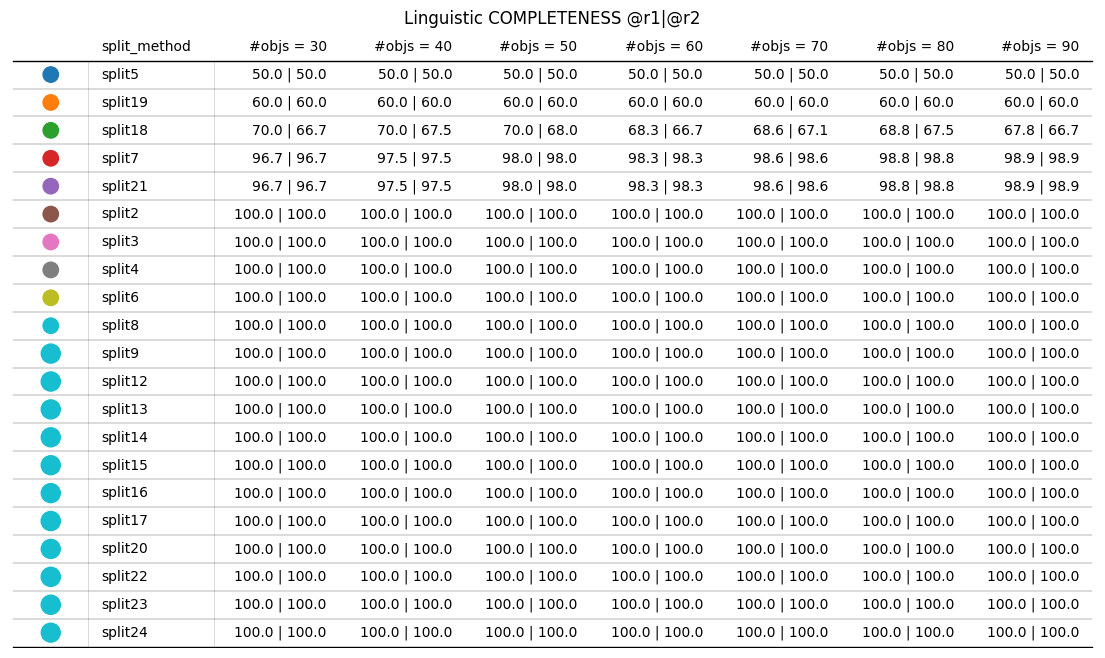

In [62]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=True)
        scores[split].append(COMPLETENESS_tworoles(num_nouns, df))
plot_CPL_table(scores, "Linguistic COMPLETENESS @r1|@r2")

In [20]:
def BALANCE_tworoles(num_nouns, df):
    summation = 0
    count_all = len(df)
    for i in range(num_nouns):
        count_O_c_i = len(df[(df.O1 == i) | (df.O2 == i)])
        count_O1_c_i = len(df[(df.O1 == i)])
        count_O2_c_i = len(df[(df.O2 == i)])
        delta = 0
        if count_O1_c_i > 0:
            delta -= count_O1_c_i * np.log(count_O1_c_i / count_O_c_i)
        if count_O2_c_i > 0:
            delta -= count_O2_c_i * np.log(count_O2_c_i / count_O_c_i)
        summation +=  delta
    summation /= count_all*2
    summation /= np.log(2) # normalize by log(M), M = num_roles
    return round(summation*100, 2)

In [66]:
def plot_BLC_table(scores, title):
    scores = dict(sorted(scores.items(), key=lambda x: x[1][0]))

    column_names = ["legend", "split_method"] + [f"#objs = {n}" for n in N]
    df = pd.DataFrame(columns=column_names)
    for i, s in enumerate(scores):
        df.loc[i] = [i, s] + [f"{x:.2f}" for x in scores[s]]
    df = df.set_index("legend")

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111)

    col_defs = [ColumnDefinition(
                name="legend",
                border="",
                width=0.6,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.05},
                    "alpha": 0,
                },
                cmap=matplotlib.cm.tab10, #normed_cmap(df['legend'], cmap=matplotlib.cm.tab10, num_stds=2.5),
            ),
            ColumnDefinition(
                name="split_method",
                title="split_method",
                border="left right",
                width=1.0,
                textprops={"ha": "left", "fontsize": 11,},
            )] + [ 
            ColumnDefinition(
                name=f"#objs = {n}",
                title=f"#objs = {n}",
                border="",
                textprops={"ha": "right", "fontsize": 11},
            ) for n in N]

    tab = Table(df,
                ax=ax,
                column_definitions = col_defs,
                column_border_kw={"linewidth": 0.5, "color": "black", "linestyle": "-", "alpha": 0.2},
                footer_divider=True,
                )
    ax.set_title(title)
    plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


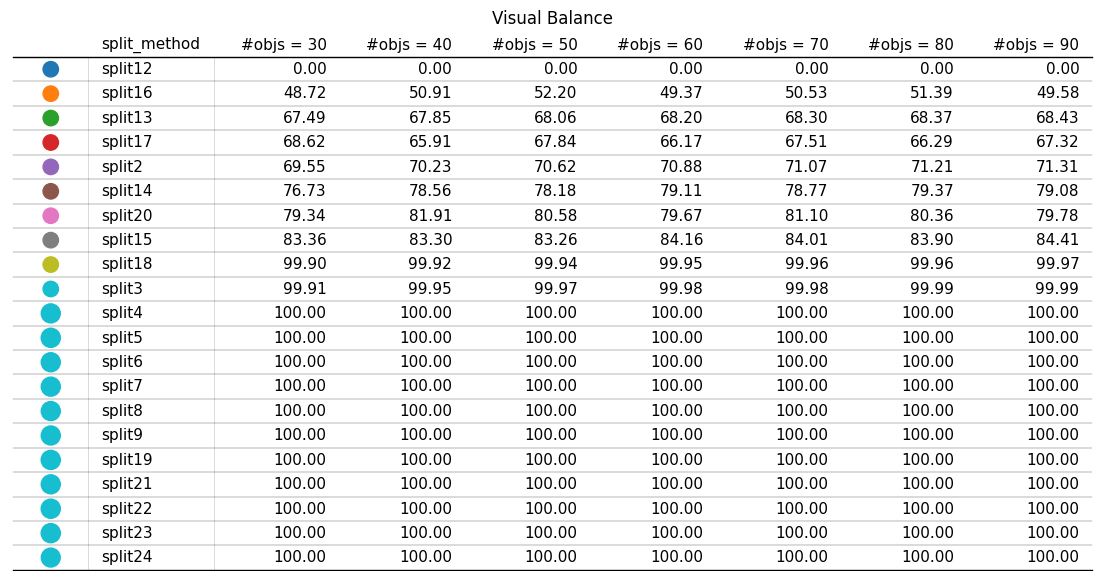

In [67]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=False)
        scores[split].append(BALANCE_tworoles(num_nouns, df))
plot_BLC_table(scores, "Visual Balance")

100%|██████████| 21/21 [00:05<00:00,  3.98it/s]


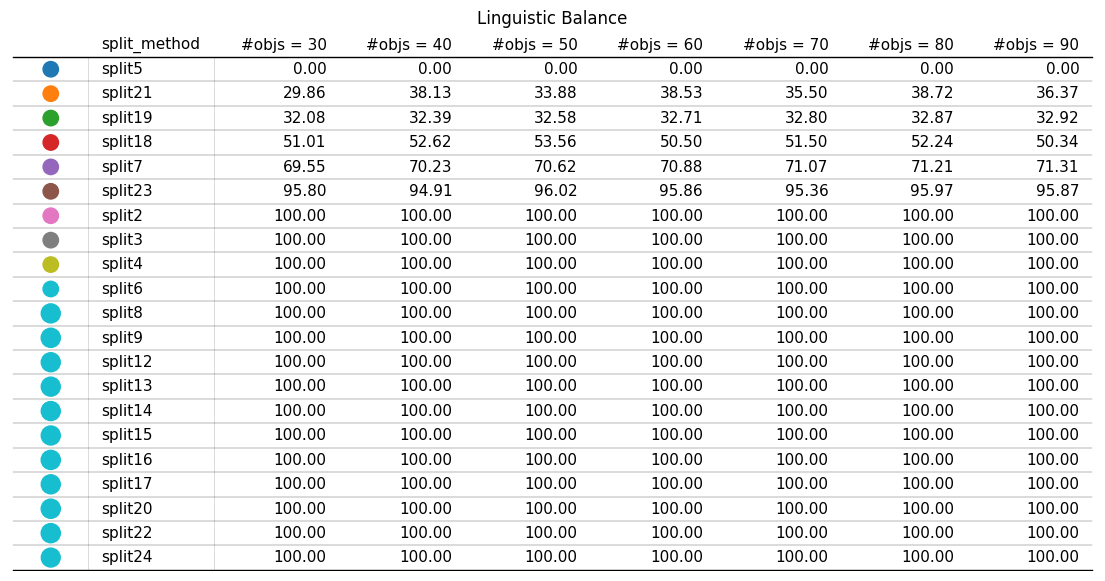

In [68]:
scores = defaultdict(list)
for split in tqdm(SPLITS):
    for num_nouns in N:
        df = create_synthetic_df(split, num_nouns, transpose=True)
        scores[split].append(BALANCE_tworoles(num_nouns, df))
plot_BLC_table(scores, "Linguistic Balance")

30